In [69]:
import requests
import json
import pandas as pd
import datetime

response = requests.get("https://climatedataapi.azurewebsites.net/api/data")
df = pd.DataFrame(json.loads(response.content.decode("utf-8")))

df["datetime"] = pd.to_datetime(df.ti)
df["te_F"] = df.te * 9/5 + 32

print("Room Climate Data")
display(df)


timezone = datetime.timedelta(0,0,0,0,0,-7)
intial_date = datetime.datetime(2022, 2, 6, 23) - timezone

response = requests.get(f"https://api.weather.gov/stations/KIWA/observations?start={intial_date.isoformat()}Z")
raw_weather_data = json.loads(response.content.decode("utf-8"))

weather_data = []
for raw_data in raw_weather_data["features"]:
    temperature = raw_data["properties"]["temperature"]["value"]
    humidity = raw_data["properties"]["relativeHumidity"]["value"]
    timestamp = raw_data["properties"]["timestamp"]
    if (temperature is None) or (humidity is None) or (timestamp is None):
        continue
    weather_data.append({
        "timestamp": pd.to_datetime(timestamp) + timezone,
        "temperature": temperature * 9/5 + 32,
        "humidity": humidity
    })

weather_df = pd.DataFrame(weather_data).sort_values(by="timestamp")
print("\nWeather Climate Data")
display(weather_df)

Room Climate Data


,id,rm,ti,te,hu,datetime,te_F
0,1,Ryan,2022-02-06T23:00:00,25,21,2022-02-06 23:00:00,77.0
1,2,Lyndi,2022-02-06T23:00:00,21,33,2022-02-06 23:00:00,69.8
2,3,Darrin,2022-02-06T23:00:00,25,26,2022-02-06 23:00:00,77.0
3,4,Logan,2022-02-06T23:00:00,25,24,2022-02-06 23:00:00,77.0
4,5,Master,2022-02-06T23:00:00,24,26,2022-02-06 23:00:00,75.2
...,...,...,...,...,...,...,...
340,341,Ryan,2022-02-09T19:00:00,28,18,2022-02-09 19:00:00,82.4
341,342,Darrin,2022-02-09T19:00:00,26,22,2022-02-09 19:00:00,78.8
342,343,Master,2022-02-09T19:00:00,25,28,2022-02-09 19:00:00,77.0
343,344,Logan,2022-02-09T19:00:00,27,20,2022-02-09 19:00:00,80.6



Weather Climate Data


,timestamp,temperature,humidity
31,2022-02-06 23:50:00+00:00,59.00,13.257949
19,2022-02-07 00:15:00+00:00,58.82,12.606308
72,2022-02-07 00:35:00+00:00,58.28,12.852452
58,2022-02-07 00:55:00+00:00,57.92,12.704886
70,2022-02-07 01:35:00+00:00,56.48,13.824736
...,...,...,...
38,2022-02-09 14:50:00+00:00,75.20,9.629486
14,2022-02-09 15:50:00+00:00,77.00,8.379333
74,2022-02-09 16:55:00+00:00,77.00,7.136839
32,2022-02-09 17:55:00+00:00,71.60,10.868574


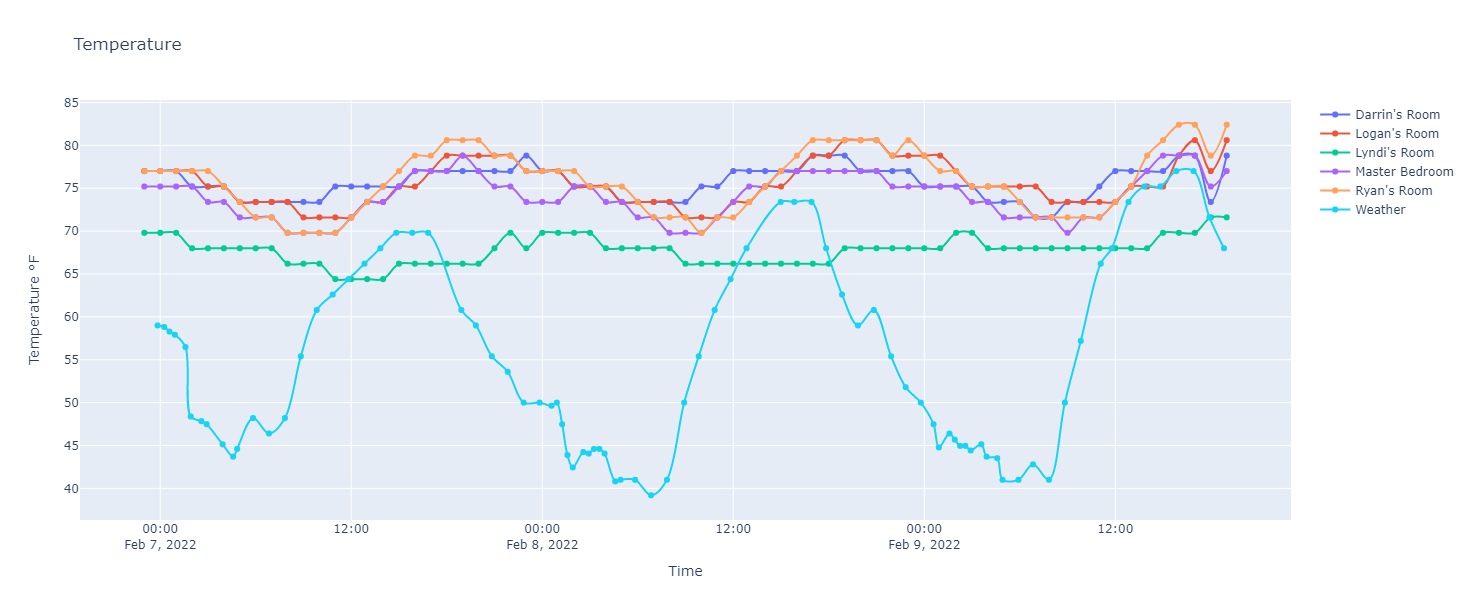

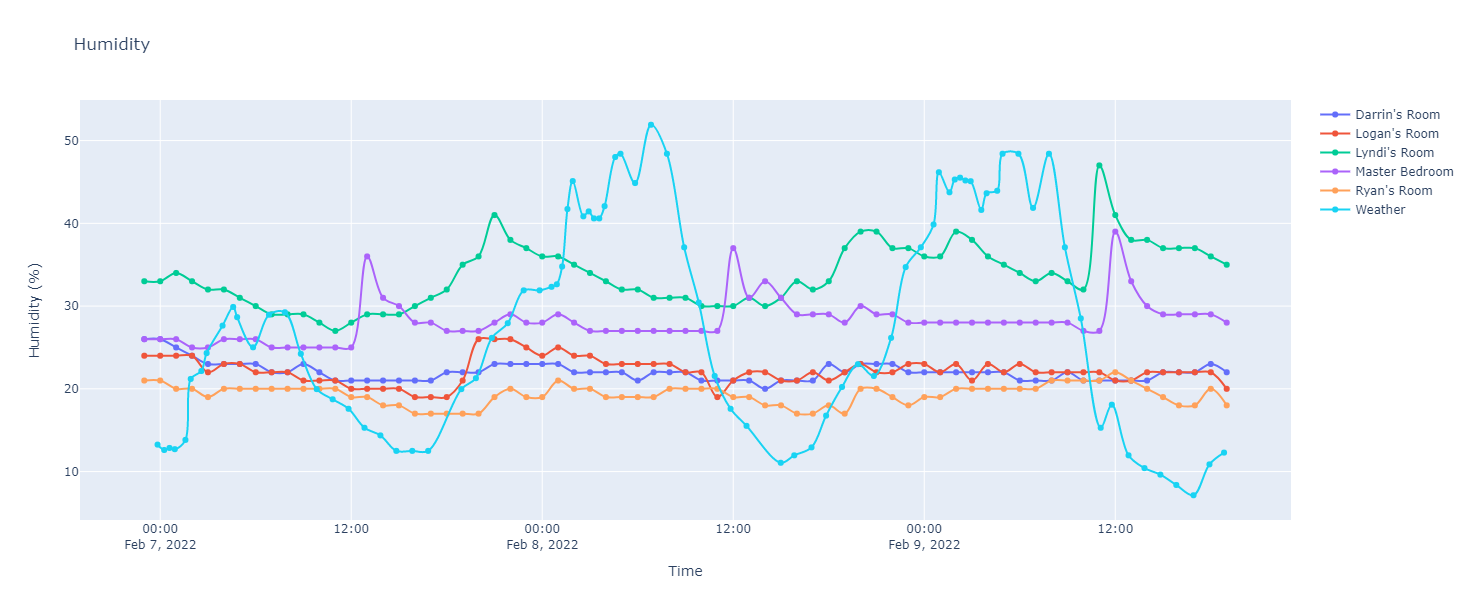

In [70]:
from plotly import graph_objects as go

figs = {}

def create_fig(fig_name, units):
    figs[fig_name] = go.Figure()
    figs[fig_name].update_layout(title=fig_name, xaxis_title="Time", yaxis_title=f"{fig_name} {units}", height=600)

create_fig("Temperature", "\N{DEGREE SIGN}F")
create_fig("Humidity", "(%)")

def create_trace(room, x, y):
    room_name = (room if room == "Weather" else f"{room} Bedroom" if room == "Master" else f"{room}'s Room")
    return go.Scatter(x=x, y=y, mode="lines+markers", text=room_name, name=room_name, line_shape="spline")

for room, room_data in df.groupby(by="rm"):
    figs["Temperature"].add_trace(create_trace(room, room_data.datetime, room_data.te_F))
    figs["Humidity"].add_trace(create_trace(room, room_data.datetime, room_data.hu))
figs["Temperature"].add_trace(create_trace("Weather", weather_df.timestamp, weather_df.temperature))
figs["Humidity"].add_trace(create_trace("Weather", weather_df.timestamp, weather_df.humidity))

for fig in figs:
    figs[fig].show()